# COVID-19와 IT 산업 환경 변화

### 신용카드 매출액 데이터를 활용한 소비시장 분석

* COVID-29 강혜선 김덕우 서우린

# 1. 서론
왜 코로나 시대에 IT산업 성장에 주목해야 하는가

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import pandas as pd
import os
from glob import glob
import numpy as np
import warnings
warnings.filterwarnings('ignore')
font_path = '/content/drive/MyDrive/datacon_data/fonts/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
# label_name = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_name) 

In [2]:
# 코로나 확진자 월별 변환 함수
def convert_monthly(data,start = '202001',end = '202203'):
  data['date'] = data['일자'].str.slice(0,7)
  data['date'] = data['date'].str.replace('-', '')
  data.drop(['일자'],axis=1,inplace=True)
  data.replace('-','0',inplace=True)
  data.replace(np.NaN,'0',inplace=True)
  cl = list(data.columns)
  c = [cl[i] for i in range(len(cl)) if not 'Unnamed' in cl[i]]
  data = data[c]
  data = data.drop([data.index[0]])
  for i in c[:-1]:
    data[i] = data[i].str.replace(',', '').astype('int64')
  data = data.groupby('date',axis=0)[c[:-1]].sum()
  data = data.loc[start:end]
  return data

In [3]:
def load_data(df,cols,paths):
  ret = pd.read_csv(paths,sep='\n',names=['text'])
  temp = ret.text.str.split("^")
  t = pd.DataFrame(temp)
  t = pd.DataFrame(list(t['text']),columns=cols)
  df = df.append(t,ignore_index=True)
  return df

# 2. 본론 - 1
코로나 현황 분석
* 코로나 확진자 추이 (20년 1월 ~ 20년 6월)
  * 신천지 집단 감염으로 3월 한달 확진자가 급증
  * 집단 감염 이후 4월 중순부터 안정기로 접어듬
  * 1` ~ `3월까지 코로나 확산기, 4` ~ `6월까지를 안정기로 구분

In [4]:
#코로나 확진자 정보
path = '/content/drive/MyDrive/datacon_data/data/covid/'
pathlist = glob(path+'*.csv')
print(pathlist)

['/content/drive/MyDrive/datacon_data/data/covid/covid_220306.csv', '/content/drive/MyDrive/datacon_data/data/covid/covid(old)_220306.csv', '/content/drive/MyDrive/datacon_data/data/covid/covid(gender)_220306.csv', '/content/drive/MyDrive/datacon_data/data/covid/covid(city)_220306.csv']


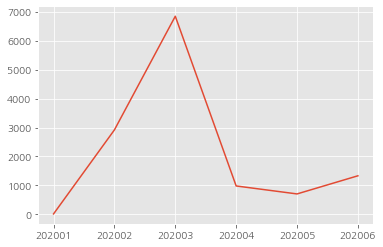

In [5]:
df = pd.read_csv(pathlist[0],encoding='euc-kr')
df = convert_monthly(df,end = '202006')
plt.style.use('ggplot')
plt.grid(True)
plt.plot(df['계(명)'])
plt.show()

# 본론 - 2
소비 시장 분석 - 데이터 분석
* 카드 사용 금액 정보 
* 전연령 및 전국 단위 데이터(기존 데이터는 연령별, 지역별로 세분화 되어있습니다.)
* 260여개의 세부 업종 분류

In [6]:
cardpath = '/content/drive/MyDrive/datacon_data/data/card/'
cardpaths = glob(cardpath+'*.csv')
cols = ['date','업종','세부업종','연령대','성별','시','구','매출','거래량']
card = pd.DataFrame(columns=cols)
for i in cardpaths:
  card = load_data(card,cols,i)

In [7]:
# 필요없는 컬럼 삭제
card.drop(['연령대','성별','시','구'],axis=1,inplace=True)

In [8]:
card.tail(10)

,date,업종,세부업종,매출,거래량
7529497,202201,기타,비 영 리,188,253
7529498,202201,기타,기타전문점,356,720
7529499,202201,기타,기타전문점,49,126
7529500,202201,기타,기타전문점,58,100
7529501,202201,기타,기타전문점,208,175
7529502,202201,기타,기계 공구,90,91
7529503,202201,기타,기계 공구,169,64
7529504,202201,기타,비 영 리,39,86
7529505,202201,기타,비 영 리,29,23
7529506,202201,기타,기타전문점,125,143


In [9]:
type_ = set(card['업종'])
type_ = list(type_)
kind = set(card['세부업종'])
kind = list(kind)
print('업종의 개수 : {} , 세부업종의 개수 : {}'.format(len(type_),len(kind)))

업종의 개수 : 36 , 세부업종의 개수 : 258


* 대표 업종 비교를 위해 36개의 업종으로 비교

In [10]:
card.drop(['세부업종'],axis=1,inplace=True)
print(type_)

['농업', '음식료품', '레져업소', '사무/통신기기', '연료판매', '의류', '휴게', '유통업비영리', '당사통신판매업소', '신변잡화', '직물', '가전제품', '학원', '건강식품', '단란주점(음식)', '건축/자재', '일반음식', '주방용품', '유통업영리', '보건/위생', '의료기관', '광학제품', '기타', '숙박업', '회원제형태업소', '용역서비스', '보험', '가구', '문화/취미', '유흥주점(음식)', '자동차정비/유지', '여행업', '서적/문구', '자동차판매', '레져용품', '수리서비스']


* (데이터 전처리)
  * 월 단위 분석이 어려운 데이터 제거
  * 매 포함되지 않는 소비 항목 제거
  * 세부 분류를 유추할 수 없는 항목 제거
  * 소비와 연관성이 적은 항목 제거
  * 계절성이 짙어서 분석이 어려운 항목 제거

In [11]:
# 제거할 업종(추후 수정 필요)
del_type = ['레져업소','문화/취미','유통업비영리','레져용품','농업','기타']

type_ = [t for t in type_ if t not in del_type]
print(type_)
print('업종의 개수 : {}'.format(len(type_)))

['음식료품', '사무/통신기기', '연료판매', '의류', '휴게', '당사통신판매업소', '신변잡화', '직물', '가전제품', '학원', '건강식품', '단란주점(음식)', '건축/자재', '일반음식', '주방용품', '유통업영리', '보건/위생', '의료기관', '광학제품', '숙박업', '회원제형태업소', '용역서비스', '보험', '가구', '유흥주점(음식)', '자동차정비/유지', '여행업', '서적/문구', '자동차판매', '수리서비스']
업종의 개수 : 30


* 업종별 월단위 소비금액

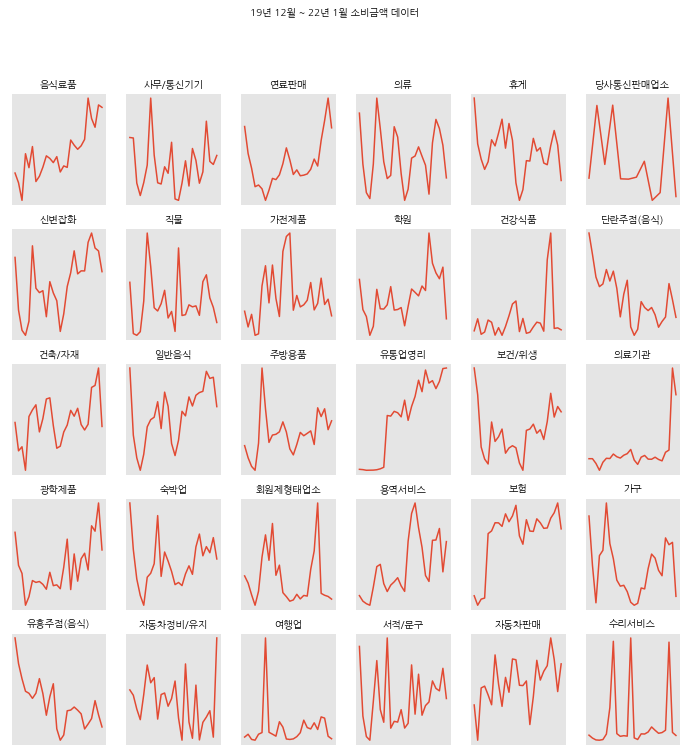

In [12]:
plt.figure(figsize = (12,12))
for i,ty in enumerate(type_):
  sub = card.loc[card['업종']==ty]
  sub['매출'] = sub['매출'].astype('int32')
  sub = sub.groupby('date',axis = 0)['매출'].sum()
  # sub = np.log(sub)
  plt.style.use('ggplot')
  # plt.grid(True)
  
  plt.subplot(5,6,i+1)
  plt.plot(sub)
  ax = plt.gca()
  plt.title(ty,fontproperties=font_name)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # plt.xlabel('date',fontproperties=font_name)
  # plt.ylabel('매출',fontproperties=font_name)
plt.suptitle('19년 12월 ~ 22년 1월 소비금액 데이터',fontsize=20,fontproperties=font_name)
plt.show()

* 평가 기준 - 타격지수(Risk Index)
  * 해당 업종의 소비가 얼마나 많이 증가/감소 했는지 나타내는 지수
  > $$RiskIndex = \sqrt{(R1+1)*(R2+1))}-1$$
  * 소비 변화율을 기하 평균으로 표현

In [13]:
def norm(l):
  mean = np.mean(l)
  std = np.sqrt(np.var(l))
  return (l-mean)/std
def RiskIndex(l):
  ret = 1
  for i in l:
    ret *= (i+1)
  return (ret**(1/len(l)))-1

In [14]:
# # 추후 계산 필요
# sub = card.loc[card['업종']=='음식료품']
# sub['매출'] = sub['매출'].astype('int32')
# sub = sub.groupby('date',axis = 0)['매출'].sum().astype('float')
# #sub = norm(sub)
# print(sub)
# print(RiskIndex(sub))

* 매출 증가 업종 - 비대면 서비스 관련 산업

In [15]:
increase = ['음식료품','유통업영리','의료기관']

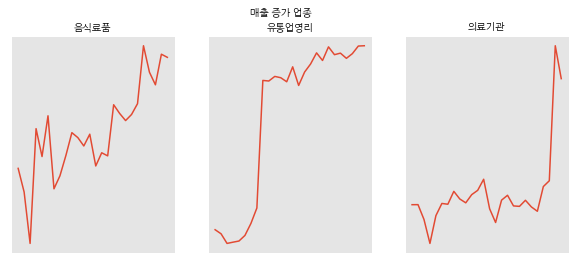

In [16]:
plt.figure(figsize = (10,4))
for i,ty in enumerate(increase):
  sub = card.loc[card['업종']==ty]
  sub['매출'] = sub['매출'].astype('int32')
  sub = sub.groupby('date',axis = 0)['매출'].sum()
  sub = np.log(sub)
  plt.style.use('ggplot')
  # plt.grid(True)
  
  plt.subplot(1,3,i+1)
  plt.plot(sub)
  ax = plt.gca()
  plt.title(ty,fontproperties=font_name)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.suptitle('매출 증가 업종',fontsize=20,fontproperties=font_name)
plt.show()

* 소비 감소 업종 - 여행,숙박,문화 산업

In [17]:
decrease = ['여행업','휴게','유흥주점(음식)']

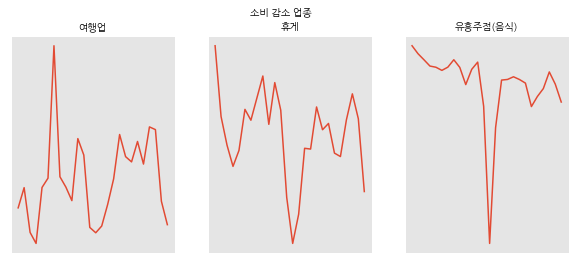

In [18]:
plt.figure(figsize = (10,4))
for i,ty in enumerate(decrease):
  sub = card.loc[card['업종']==ty]
  sub['매출'] = sub['매출'].astype('int32')
  sub = sub.groupby('date',axis = 0)['매출'].sum()
  sub = np.log(sub)
  plt.style.use('ggplot')
  # plt.grid(True)
  
  plt.subplot(1,3,i+1)
  plt.plot(sub)
  ax = plt.gca()
  plt.title(ty,fontproperties=font_name)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.suptitle('소비 감소 업종',fontsize=20,fontproperties=font_name)
plt.show()

### 산업 구조 분석

* 산업별 고용률 변화
  * 통계청, ~22.01

In [19]:
recruitpath = '/content/drive/MyDrive/datacon_data/data/recruitment/recruit.csv'
recruit = pd.read_csv(recruitpath,encoding='euc-kr')
recruit.columns = recruit.columns.str.replace('. ', '')
recruit.set_index('date',inplace = True)
recruit = recruit.transpose()
recruit.head(5)

date,전체,B.광업(05~08),C.제조업(10~34),"D.전기, 가스, 증기 및 공기 조절 공급업(35)","E.수도, 하수 및 폐기물 처리, 원료 재생업(36~39)",F.건설업(41~42),G.도매 및 소매업(45~47),H.운수 및 창고업(49~52),I.숙박 및 음식점업(55~56),J.정보통신업(58~63),K.금융 및 보험업(64~66),L.부동산업(68),"M.전문, 과학 및 기술 서비스업(70~73)","N.사업시설 관리, 사업 지원 및 임대 서비스업(74~76)","O.공공행정, 국방 및 사회보장 행정(84)",P.교육 서비스업(85),Q.보건업 및 사회복지 서비스업(86~87),"R.예술, 스포츠 및 여가관련 서비스업(90~91)","S.협회 및 단체, 수리 및 기타 개인 서비스업(94~96)"
201901,847824,570,129893,1143,4224,166211,76475,24262,104362,17625,9831,15678,34421,93170,28591,29269,69831,17605,24662
201902,700088,655,106951,513,3091,150887,80632,15696,103238,12222,5689,9400,24476,55105,15911,22328,62589,13001,17703
201903,1078657,881,121102,720,4041,246954,89722,22950,119082,14221,6321,11159,28718,68422,27832,170283,105608,18789,21852
201904,880406,838,129647,877,4357,254623,83617,18940,112907,15823,7383,11506,27341,75926,13453,25964,62895,15827,18482
201905,836176,749,113919,768,3897,274537,68553,20409,110914,12140,5486,10810,23972,70825,11751,21114,53820,13189,19324


In [20]:
recruit.drop(['전체'],axis=1,inplace=True)
r_cols = list(recruit.columns)

In [21]:
recruit = recruit.loc['202001':]

In [22]:
# list percent convert
def list_percentage(l):
  c = l[0]
  for i,a in enumerate(l):
    l[i] = (a/c)*100

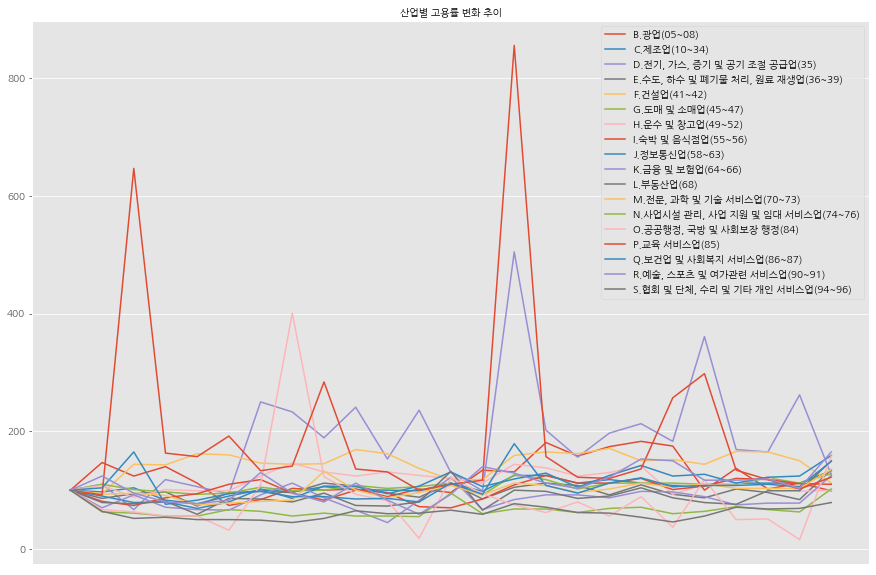

In [27]:
plt.figure(figsize = (15,10))
for ty in r_cols:
  sub = recruit[ty]
  list_percentage(sub)
  plt.style.use('ggplot')
  plt.plot(sub,label=ty)
  ax = plt.gca()
  ax.get_xaxis().set_visible(False)
  #ax.get_yaxis().set_visible(False)
plt.title('산업별 고용률 변화 추이',fontsize = 20,fontproperties=font_name)
plt.legend(loc='upper right')
plt.show()